# Persistent Homology Figures

This notebook creates figures used to explain several concepts from simplicial
persistent homology, including simplicial complexes, barcodes, persistence
diagrams, Vietoris-Rips complexes, and minimal presentations.

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import pandas as pd

from biperscan import BPSCAN

from lib.plotting import *
from matplotlib.colors import Normalize, to_rgb, ListedColormap
from matplotlib.lines import Line2D

tab10 = configure_matplotlib()

In [3]:
df = pd.read_csv('data/five_circles/five_circles.csv')
x = df.x[0:224:3].to_numpy()
y = df.y[0:224:3].to_numpy() / (1 / 0.618)
pos = np.concatenate((x[np.newaxis].T, y[np.newaxis].T), axis = 1)

## Persistent Homology

In [ ]:
from gtda.plotting import plot_diagram
from gtda.homology import VietorisRipsPersistence

VR = VietorisRipsPersistence(homology_dimensions=[0, 1], 
                             reduced_homology=False,
                             n_jobs=1)
diagrams = VR.fit_transform([pos])

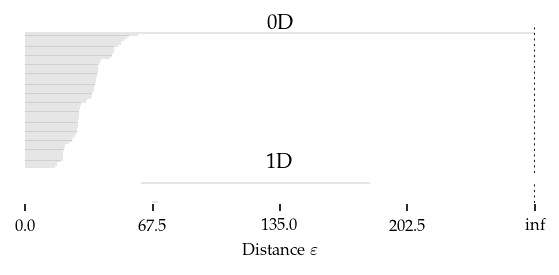

In [19]:
from matplotlib import gridspec


sized_fig(0.66, aspect = 0.618/2/0.66)
gs = gridspec.GridSpec(2, 1, height_ratios=[7, 1]) 

ylabels = ['Connected components', 'Loops']
ds = [0, 1]
inf_value = 270
for j, d in enumerate(ds):
  ax = plt.subplot(gs[j])
  components = diagrams[0][diagrams[0][:, 2] == d]
  for i, pair in enumerate(components):
    plt.plot([pair[0], pair[1] if not np.isinf(pair[1]) else inf_value], [i, i], 'k-', linewidth=0.1)
  plt.plot([inf_value, inf_value], plt.ylim(), 'k:', linewidth=1)

  plt.yticks([])
  ax.set_title(f'{j}D', y=1, pad=-5 if j == 0 else None)
  plt.xlim([0, inf_value])

  if j == 0:
    ax.set_xticks([])
    plt.xlabel('')
  else:
    ticks = np.linspace(0, inf_value, 5)
    labels = [
      f'{t}' if t != inf_value else 'inf'
      for t in ticks
    ]
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    plt.xlabel('Distance $\\varepsilon$')
    
plt.subplots_adjust(0.03, 0.23, .97, .96, hspace=0)
plt.savefig('./images/barcode.pdf', pad_inches=0)
plt.show()

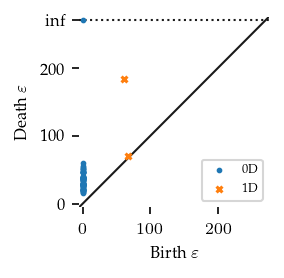

In [20]:
sized_fig(0.33, aspect=0.618 / 2 / 0.33)

markers = ["o", "x"]

for i, d in enumerate(ds):
    components = diagrams[0][diagrams[0][:, 2] == d]
    components[np.isinf(components[:, 1]), 1] = inf_value
    plt.scatter(
        components[:, 0],
        components[:, 1],
        s=3 if i == 0 else 8,
        marker=markers[i],
    )


lim = [-5, inf_value + 5]
plt.xlim(lim)
plt.ylim(lim)
plt.plot(lim, [inf_value, inf_value], "k:", linewidth=1, zorder=-1)
plt.plot(lim, lim, "k-", linewidth=1, zorder=-1)
plt.legend(['0D', '1D'], loc='lower right')
plt.xlabel("Birth $\\varepsilon$")
plt.ylabel("Death $\\varepsilon$")
plt.gca().set_yticks([0, 100, 200, inf_value])
plt.gca().set_yticklabels(['0', '100', '200', 'inf'])
plt.subplots_adjust(0.28, 0.23, .98, .98)
plt.savefig('./images/diagram.pdf', pad_inches=0)
plt.show()

## Vietoris-Rips complexes

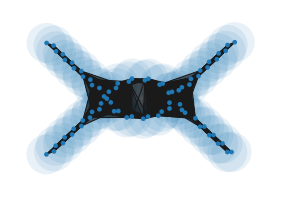

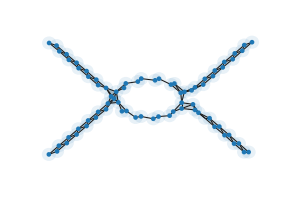

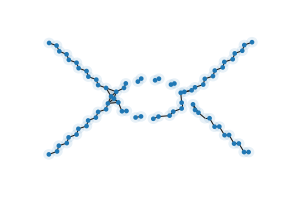

In [18]:
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import coo_matrix
import networkx as nx

dists = pdist(pos)
dists_list = np.sort(dists)

xlim = None
ylim = None

for threshold in [95, 31, 25]:
    edges = dists < (threshold * 2)
    edges = coo_matrix(squareform(edges))
    edges.eliminate_zeros()
    g = nx.Graph(edges)

    faces = []
    for source in range(edges.shape[0]):
        for neighbor in g.neighbors(source):
            for second_degree in g.neighbors(neighbor):
                if source in g.neighbors(second_degree):
                    faces.append((source, neighbor, second_degree))

    poly = [
        [
            (x[faces[i][0]], y[faces[i][0]]),
            (x[faces[i][1]], y[faces[i][1]]),
            (x[faces[i][2]], y[faces[i][2]]),
        ]
        for i in range(len(faces))
    ]

    fig = sized_fig(0.33)
    ax = plt.gca()

    edge_list, _ = zip(*nx.get_edge_attributes(g, "weight").items())
    edge_colors = [(x[e[0]] + x[e[1]]) / 2 for e in edge_list]
    node_list = list(range(edges.col.max()))
    node_colors = x[node_list]

    for i in range(len(x)):
        ax.add_patch(
            plt.Circle(
                (x[i], y[i]),
                threshold,
                facecolor="C0",
                alpha=0.1,
                zorder=-2,
                linewidth=0,
                edgecolor="none",
            )
        )

    for face in range(len(faces)):
        p = plt.Polygon(poly[face], fc="k", ec="none", alpha=0.015, zorder=-1)
        ax.add_patch(p)

    nx.draw_networkx(
        g,
        pos=pos,
        ax=ax,
        edgelist=edge_list,
        nodelist=node_list,
        edge_color="k",
        node_color="C0",
        width=0.5,
        node_size=5,
        with_labels=False,
        linewidths=0,
        edgecolors="none",
    )

    plt.axis("off")
    if xlim is None:
        ax.set_aspect("equal")
        xlim = plt.xlim()
        ylim = plt.ylim()
    else:
        plt.xlim(xlim)
        plt.ylim(ylim)
    plt.subplots_adjust(0, 0, 1, 1)
    plt.savefig(f"./images/vietoris_rips_{threshold}.pdf", pad_inches=0)
    plt.show()

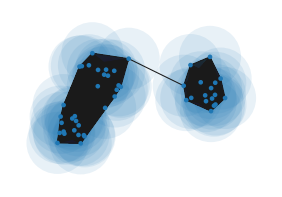

In [ ]:
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import coo_matrix
from sklearn.datasets import make_blobs
import networkx as nx


X, _ = make_blobs(50, centers=3)
dists = pdist(X)
dists_list = np.sort(dists)


xlim = None
ylim = None

for threshold in [2.7, 1.4, 1]:
    edges = dists < (threshold * 2)
    edges = coo_matrix(squareform(edges))
    edges.eliminate_zeros()
    g = nx.Graph(edges)

    faces = []
    for source in range(edges.shape[0]):
        for neighbor in g.neighbors(source):
            for second_degree in g.neighbors(neighbor):
                if source in g.neighbors(second_degree):
                    faces.append((source, neighbor, second_degree))

    poly = [
        [
            (X[faces[i][0], 0], X[faces[i][0], 1]),
            (X[faces[i][1], 0], X[faces[i][1], 1]),
            (X[faces[i][2], 0], X[faces[i][2], 1]),
        ]
        for i in range(len(faces))
    ]

    fig = sized_fig(0.33)
    ax = plt.gca()

    edge_list, _ = zip(*nx.get_edge_attributes(g, "weight").items())
    edge_colors = [(X[e[0], 0] + X[e[1], 0]) / 2 for e in edge_list]
    node_list = list(range(edges.col.max()))
    node_colors = X[node_list, 0]

    for i in range(len(X)):
        ax.add_patch(
            plt.Circle(
                (X[i, 0], X[i, 1]),
                threshold,
                facecolor="C0",
                alpha=0.1,
                zorder=-2,
                linewidth=0,
                edgecolor="none",
            )
        )

    for face in range(len(faces)):
        p = plt.Polygon(poly[face], fc="k", ec="none", alpha=0.015, zorder=-1)
        ax.add_patch(p)

    nx.draw_networkx(
        g,
        pos=X,
        ax=ax,
        edgelist=edge_list,
        nodelist=node_list,
        edge_color="k",
        node_color="C0",
        width=0.5,
        node_size=5,
        with_labels=False,
        linewidths=0,
        edgecolors="none",
    )

    plt.axis("off")
    if xlim is None:
        ax.set_aspect("equal")
        xlim = plt.xlim()
        ylim = plt.ylim()
    else:
        plt.xlim(xlim)
        plt.ylim(ylim)
    plt.subplots_adjust(0, 0, 1, 1)
    plt.savefig(f"./images/vietoris_rips_blobs_{threshold}.pdf", pad_inches=0)
    plt.show()

## Minimal Simplicial Complex

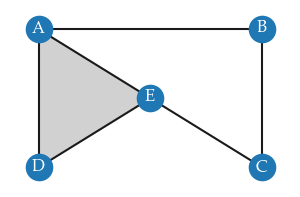

In [ ]:
X = np.array([[0, 1], [2, 1], [2, 0], [0, 0], [1, 0.5]])
edges = np.array([[0, 1], [1, 2], [3, 0], [0, 4], [2, 4], [3, 4]])
faces = np.array([[0, 3, 4]])

g = nx.from_edgelist(edges)
letters = ["A", "B", "C", "D", "E"]

sized_fig(0.33)
for face in faces:
    poly = plt.Polygon(
        np.asarray([X[face[0]], X[face[1]], X[face[2]]]),
        fc="k",
        ec="none",
        alpha=0.2,
        zorder=-1,
    )
    plt.gca().add_patch(poly)

nx.draw_networkx(
    g,
    pos=X,
    node_size=150,
    with_labels=True,
    labels={i: letters[i] for i in range(X.shape[0])},
    font_color="w",
    font_size=8,
)
plt.axis("off")
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig("./images/simple_complex.pdf", pad_inches=0)

## Minima Presentation Demonstration

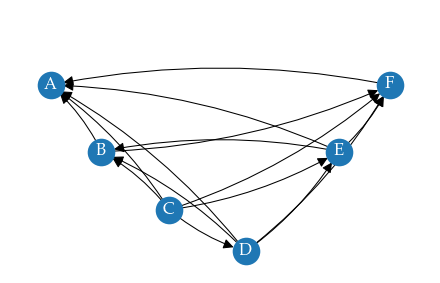

In [4]:
import networkx as nx

from scipy.stats import rankdata
from scipy.spatial.distance import pdist, squareform
from biperscan.lenses import negative_eccentricity
from lib.drawing import plot_graph
from itertools import product


X = np.array(
    [
        [-2, 2],
        [2, 2],
        [-1.4, 1.2],
        [1.4, 1.2],
        [0.3, 0],
        [-0.6, 0.5],
    ]
)
dist = pdist(X)
lens = negative_eccentricity(X, dist)
lens_grades = rankdata(lens, method="dense")
dist_grades = squareform(rankdata(dist, method="ordinal"))
letters = np.array(["A", "F", "B", "E", "D", "C"])

g = nx.DiGraph()
for i, j in product(range(X.shape[0]), range(X.shape[0])):
    if i < j:
        g.add_edge(
            j,
            i,
            grade=f"({int(max(lens_grades[i], lens_grades[j]))}, {int(dist_grades[i, j])})",
        )

sized_fig(0.5)
plot_graph(g, X, labels={i: l for i, l in enumerate(letters)}, edge_labels=False)
plt.subplots_adjust(0, 0, 1, 1)
plt.ylim([-0.2,2.85])
plt.axis("off")
plt.savefig("./images/complex_for_minpres_demo.pdf", pad_inches=0)
plt.show()

In [16]:
lens

array([0.        , 0.        , 0.50799656, 0.50799656, 0.95363885,
       1.        ], dtype=float32)

In [5]:
all_edges = nx.to_pandas_edgelist(g)
all_edges['lens'] = all_edges['grade'].apply(lambda x: x.split(',')[0][1:]).astype(int)
all_edges['distance'] = all_edges['grade'].apply(lambda x: x.split(',')[1][:-1]).astype(int)
all_edges['parent'] = letters[np.min(all_edges[['source', 'target']].to_numpy(), axis=1)]
all_edges['child'] = letters[np.max(all_edges[['source', 'target']].to_numpy(), axis=1)]
all_edges.drop(columns=['grade', 'source', 'target'], axis=1, inplace=True)
all_edges.sort_values(['lens','distance'])

,lens,distance,parent,child
0,1,15,A,F
1,2,1,A,B
4,2,2,F,E
5,2,10,B,E
3,2,13,A,E
2,2,14,F,B
9,3,5,E,D
8,3,7,B,D
7,3,9,F,D
6,3,12,A,D


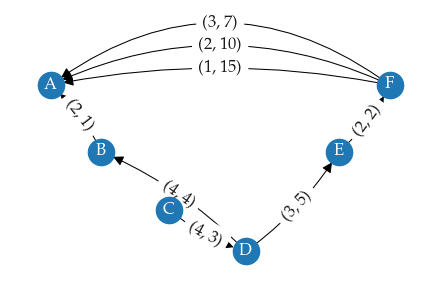

In [6]:
c = BPSCAN(metric="precomputed", lens=lens, min_cluster_size=2).fit(dist)
minpres = c.minimal_presentation_.as_pandas()
minpres["parent"] = c._row_to_point[minpres["parent"]]
minpres["child"] = c._row_to_point[minpres["child"]]
minpres['lens_grade'] += 1
minpres['distance_grade'] += 1

minpres = nx.from_pandas_edgelist(
    minpres,
    source="child",
    target="parent",
    edge_attr=["lens_grade", "distance_grade"],
    create_using=nx.MultiDiGraph,
)
nx.set_edge_attributes(
    minpres,
    values={
        (i, j, c): f'({attrs["lens_grade"]}, {attrs["distance_grade"]})'
        for i, j, c, attrs in minpres.edges(data=True, keys=True)
    },
    name="grade",
)

sized_fig(0.5)
plot_graph(minpres, X, labels={i: l for i, l in enumerate(letters)})
plt.subplots_adjust(0, 0, 1, 1)
plt.ylim([-0.2,2.85])
plt.axis("off")
plt.savefig("./images/minpres_for_minpres_demo.pdf", pad_inches=0)
plt.show()

In [7]:
all_edges = nx.to_pandas_edgelist(minpres)
all_edges['lens'] = all_edges['grade'].apply(lambda x: x.split(',')[0][1:]).astype(int)
all_edges['distance'] = all_edges['grade'].apply(lambda x: x.split(',')[1][:-1]).astype(int)
all_edges['parent'] = letters[np.min(all_edges[['source', 'target']].to_numpy(), axis=1)]
all_edges['child'] = letters[np.max(all_edges[['source', 'target']].to_numpy(), axis=1)]
all_edges.drop(columns=['grade', 'distance_grade', 'lens_grade', 'source', 'target'], axis=1, inplace=True)
all_edges.sort_values(['lens', 'distance'])

,lens,distance,parent,child
0,1,15,A,F
3,2,1,A,B
4,2,2,F,E
1,2,10,A,F
5,3,5,E,D
2,3,7,A,F
7,4,3,D,C
6,4,4,B,D


In [14]:
linkage = c.linkage_hierarchy_
linkage_df = linkage.as_pandas()
linkage_df['lens_grade'] += 1
linkage_df['distance_grade'] += 1
linkage_df['parent_root'] = letters[linkage_df['parent_root'].astype(int)]
linkage_df['child_root'] = letters[linkage_df['child_root'].astype(int)]
linkage_df['id'] = linkage_df.index + len(letters)
linkage_df = linkage_df.drop(columns=['lens_value', 'distance_value'])
linkage_df[['lens_grade', 'distance_grade', 'id', 'parent', 'child', 'parent_root', 'child_root']]

,lens_grade,distance_grade,id,parent,child,parent_root,child_root
0,1,15,6,0,1,A,F
1,2,1,7,0,2,A,B
2,2,2,8,1,3,F,E
3,2,10,9,7,8,A,F
4,3,5,10,8,4,F,D
5,3,7,11,7,10,A,F
6,4,3,12,4,5,D,C
7,4,4,13,7,12,A,D
8,4,5,14,13,10,A,F
